In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import custom helper functions
import sys
sys.path.append("../../..")
from utils.setup import Config
from utils.data import get_trade_and_book_by_stock_and_time_id
from utils.helpers import *

In [2]:
train_df = pd.read_csv(Config.data_directory / "train.csv")
train_df.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
# total number of training points
len(train_df)

428932

In [4]:
# there are 127 unique stocks we will model
stock_ids = train_df.stock_id.unique()
stock_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126], dtype=int64)

In [5]:
print(f"Average number of observations per stock: {int(len(train_df )/ 127)}")

Average number of observations per stock: 3377


count     112.000000
mean     3829.750000
std         1.700556
min      3815.000000
25%      3830.000000
50%      3830.000000
75%      3830.000000
max      3830.000000
dtype: float64

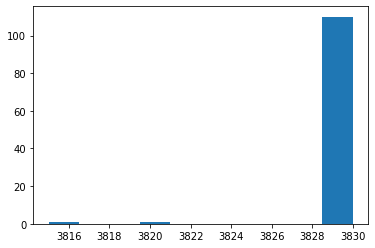

In [6]:
# look at the distribution of the observations across the stocks
display(train_df.groupby("stock_id").apply(len).describe())

plt.hist(train_df.groupby("stock_id").apply(len))
plt.show()

Comment: Basically all have 3830 observations per stock, only a few outliers.

count    3830.000000
mean      111.992689
std         0.085201
min       111.000000
25%       112.000000
50%       112.000000
75%       112.000000
max       112.000000
dtype: float64

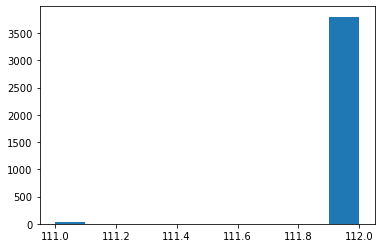

In [7]:
# look at the distribution of stocks for each time_id (i.e for each time do we have all stocks or only some)
display(train_df.groupby("time_id").apply(len).describe())
plt.hist(train_df.groupby("time_id").apply(len))
plt.show()

Comment: looks like we have most of the data on average (112 out of possible 127) but not all.

## Example

In [8]:
# taking a look at a particular stock and time id.abs

book, trade = get_trade_and_book_by_stock_and_time_id(5, 5)
book.set_index("seconds_in_bucket")
book.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,0.999749,1.001348,0.999655,1.001361,308,5,11,11,5
1,5,1,0.999749,1.001348,0.999655,1.001361,308,4,11,11,5
2,5,3,0.999749,1.001348,0.999655,1.001361,328,4,11,11,5
3,5,4,0.999749,1.001348,0.999655,1.001361,378,4,11,11,5
4,5,5,0.999776,1.001348,0.999763,1.001361,228,4,21,11,5


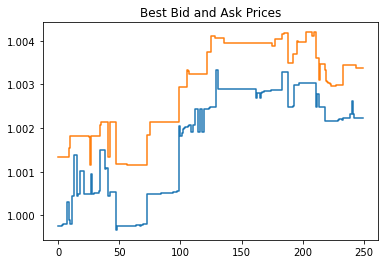

In [9]:
# best price time series
plt.step(book.index, book.bid_price1)
plt.step(book.index, book.ask_price1)
plt.title("Best Bid and Ask Prices")
plt.show()

Text(0.5, 1.0, 'Log Returns for example')

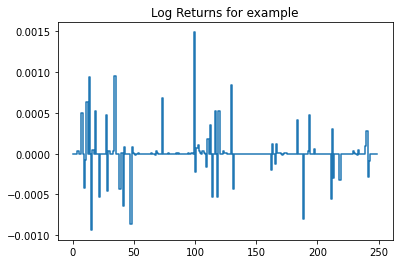

In [10]:
# look at how the returns are distributed

plt.step(book.index, log_return(book.bid_price1))
plt.title("Log Returns for example")

Text(0.5, 1.0, 'Log Returns Distribution')

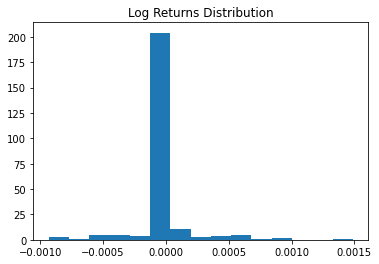

In [11]:
plt.hist(log_return(book.bid_price1), bins = 15)
plt.title("Log Returns Distribution")

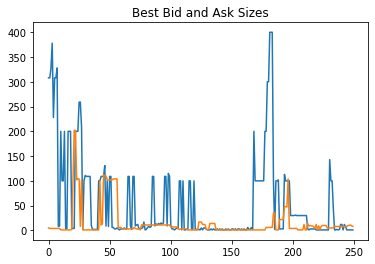

In [12]:
# liquidity on best bid and offer is imbalanced
# favours the bid side (makes sense since this stock is going up at this moment in time)
plt.plot(book.bid_size1)
plt.plot(book.ask_size1)
plt.title("Best Bid and Ask Sizes")
plt.show()

Text(0.5, 1.0, 'Relative Best Bid/Ask Spread')

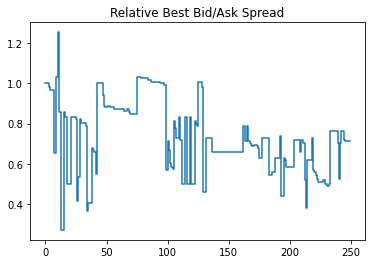

In [18]:
# look at the change in spread (would expect that if the the spread gets smaller then more likely to trade and vice versa for a wider spread - both of which could result in increased volatility.)
# normalise based on the starting value
plt.step(book.index, (book.ask_price1 - book.bid_price1)/ (book.ask_price1 - book.bid_price1).iloc[0])
plt.title("Relative Best Bid/Ask Spread")

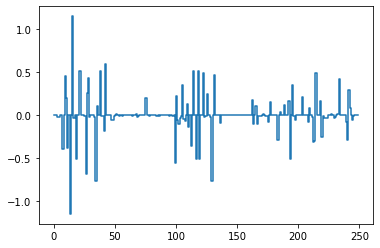

In [22]:
# we see that the spread goes through periods of volatility 
plt.step(book.index, log_return(book.ask_price1 - book.bid_price1))

In [23]:
book["vwap"] = (book["bid_price1"]*book["ask_size1"] + book["ask_price1"]*book["bid_size1"]) / (book["bid_size1"] + book["ask_size1"])

Text(0.5, 1.0, 'Volume Weighted Average Price')

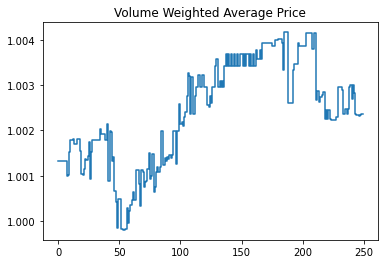

In [28]:
plt.step(book.index, book.vwap)
plt.title("Volume Weighted Average Price")

Text(0.5, 1.0, 'Log change in vol')

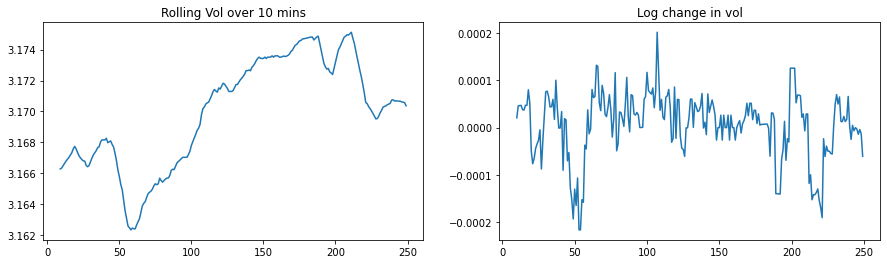

In [70]:
# lets see if the change in spread is correlated with the change in vwap price

num_obs_in_window = 10
rolling_volatility = book["vwap"].rolling(num_obs_in_window, num_obs_in_window).apply(realized_volatility).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,4))

ax1.plot(rolling_volatility)
ax1.set_title("Rolling Vol over 10 mins")

ax2.plot(log_return(rolling_volatility))
ax2.set_title("Log change in vol")

In [76]:
np.corrcoef(log_return(rolling_volatility).dropna(), log_return(book.ask_price1 - book.bid_price1).iloc[num_obs_in_window:])  # pretty much no correlation unfornuately

array([[1.        , 0.00390876],
       [0.00390876, 1.        ]])